## Feature Selection:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pickle 파일 불러오기(file -> python 객체)
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/mon_standard.pkl", "rb") as fr:
  data = pickle.load(fr)

  data = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/mon_standard.pkl', 'rb'))

In [ ]:
USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950
X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000

Total samples: 19000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({"timestamps":X1, "packet size":X2, "label": y})
# X1 = timeStamps, X2 = packet size, y = site name
df.head()

,timestamps,packet size,label
0,"[0.0, 0.14, 0.14, 0.31, 0.31, 0.51, 0.51, 0.51...","[-512, -512, 512, -512, 512, -512, 512, 512, -...",0
1,"[0.0, 0.13, 0.13, 0.31, 0.77, 1.11, 1.11, 1.11...","[-512, -512, 512, -512, 512, -512, 512, 512, -...",0
2,"[0.0, 0.11, 0.11, 0.23, 0.97, 1.11, 1.11, 1.11...","[-512, -512, 512, -512, 512, -512, 512, 512, -...",0
3,"[0.0, 0.27, 0.27, 0.6, 0.6, 0.88, 0.89, 0.89, ...","[-512, -512, 512, -512, 512, -512, 512, 512, -...",0
4,"[0.0, 0.11, 0.11, 0.36, 0.36, 0.6, 0.6, 0.6, 0...","[-512, -512, 512, -512, 512, -512, 512, 512, -...",0


In [ ]:
df.tail()

,timestamps,packet size,label
18995,"[0.0, 0.15, 0.15, 0.33, 0.91, 1.12, 1.13, 1.13...","[-512, -512, 512, -512, 512, -512, 512, 512, -...",94
18996,"[0.0, 0.16, 0.16, 0.35, 0.99, 1.26, 1.26, 1.26...","[-512, -512, 512, -512, 512, -512, 512, 512, -...",94
18997,"[0.0, 0.11, 0.11, 0.36, 0.36, 0.83, 0.83, 0.83...","[-512, -512, 512, -512, 512, -512, 512, 512, -...",94
18998,"[0.0, 0.17, 0.17, 0.32, 1.98, 2.56, 2.56, 2.56...","[-512, -512, 512, -512, 512, -512, 512, 512, -...",94
18999,"[0.0, 0.12, 0.12, 0.46, 0.46, 0.72, 0.73, 0.73...","[-512, -512, 512, -512, 512, -512, 512, 512, -...",94


## 각 feature 별 저장해주는 list 생성

In [ ]:
n_pack = [] #Array to store total number of packets
n_in = [] #Array to store number of incoming packets : server -> client (size < 0)
n_out = [] #Array to store number of outgoing packets : client -> server (size > 0)
r_in = [] #Array to store ratio of incoming packets
r_out = [] #Array to store ratio of outcoming packets
in_first = [] #Array to store number of incoming packet in First 30 Packets
out_first = [] #Array to store number of outcoming packet in First 30 Packets
transmission_time = [] #Array to store total transmission time
packets_per_sec = [] #Array to store #of packets per second

for i in range (0,len(X2)):
  count = 0
  count_30 = 0
  for j in range (0,len(X2[i])):
    if X2[i][j] < 0:
      count+=1
      if j < 30: #incoming packet이고 처음 30개 안에 해당된다면
        count_30+=1
  n_pack.append(len(X2[i]))
  n_in.append(count)
  n_out.append(len(X2[i])-count)
  r_in.append(count/len(X2[i]))
  r_out.append(1-count/len(X2[i]))
  in_first.append(count_30)
  out_first.append(30-count_30)
  transmission_time.append(X1[i][-1])
  packets_per_sec.append(len(X2[i])/X1[i][-1])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

####### 새로 df_mon 이라는 dataframe을 만들기
df_mon = pd.DataFrame({"total packets": n_pack, "#of incoming packets": n_in, "#of outgoing packets": n_out,
                       "ratio of incoming packets": r_in, "ratio of outgoing packets": r_out,
                       "#of incoming(first30)": in_first, "#of outgoing(first30)": out_first, "total time": transmission_time, "#of packets per sec": packets_per_sec, "label": y})

df_mon.head()

,total packets,#of incoming packets,#of outgoing packets,ratio of incoming packets,ratio of outgoing packets,#of incoming(first30),#of outgoing(first30),total time,#of packets per sec,label
0,1421,1300,121,0.914849,0.085151,21,9,10.14,140.138067,0
1,518,438,80,0.845560,0.154440,22,8,10.16,50.984252,0
2,1358,1240,118,0.913108,0.086892,23,7,11.11,122.232223,0
3,1446,1324,122,0.915629,0.084371,21,9,13.36,108.233533,0
4,1406,1291,115,0.918208,0.081792,22,8,10.64,132.142857,0


In [ ]:
df_mon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19000 entries, 0 to 18999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   total packets              19000 non-null  int64  
 1   #of incoming packets       19000 non-null  int64  
 2   #of outgoing packets       19000 non-null  int64  
 3   ratio of incoming packets  19000 non-null  float64
 4   ratio of outgoing packets  19000 non-null  float64
 5   #of incoming(first30)      19000 non-null  int64  
 6   #of outgoing(first30)      19000 non-null  int64  
 7   total time                 19000 non-null  float64
 8   #of packets per sec        19000 non-null  float64
 9   label                      19000 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 1.4 MB


In [ ]:
df_mon.describe()

,total packets,#of incoming packets,#of outgoing packets,ratio of incoming packets,ratio of outgoing packets,#of incoming(first30),#of outgoing(first30),total time,#of packets per sec,label
count,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.00000
mean,4188.808526,3840.845842,347.962684,0.902173,0.097827,21.779684,8.220316,28.065225,223.931263,47.00000
std,3206.123258,2991.553668,289.852424,0.046691,0.046691,1.377023,1.377023,17.672716,274.470064,27.42334
min,50.000000,25.000000,6.000000,0.492754,0.029521,13.000000,4.000000,1.600000,0.780572,0.00000
25%,1529.750000,1374.750000,137.000000,0.880489,0.064862,21.000000,7.000000,11.820000,68.057075,23.00000
50%,3309.000000,3007.500000,281.000000,0.910170,0.089830,22.000000,8.000000,25.960000,124.982902,47.00000
75%,6378.000000,5773.250000,486.000000,0.935138,0.119511,23.000000,9.000000,42.090000,240.786303,71.00000
max,9993.000000,9698.000000,4241.000000,0.970479,0.507246,26.000000,17.000000,86.020000,2127.136752,94.00000


Feature ranking:
total packets: 0.16003398142082828
#of incoming packets: 0.14981242237819264
#of outgoing packets: 0.13836257139783184
ratio of incoming packets: 0.12221956552861572
ratio of outgoing packets: 0.11889322341272679
total time: 0.11475623841673528
#of packets per sec: 0.10683602362649275
#of outgoing(first30): 0.04488782133892383
#of incoming(first30): 0.04419815247965302


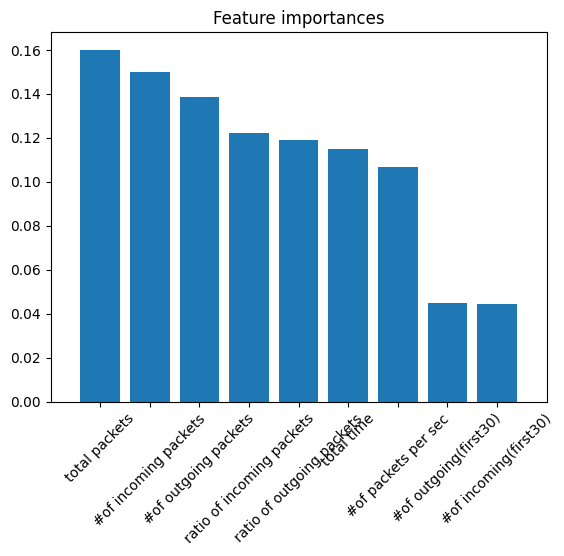

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import pandas as pd

# 데이터프레임에서 feature과 target을 추출
X = df_mon.drop('label', axis=1)
y = df_mon['label']

# 모델 초기화 (RandomForestClassifier를 사용)
model = RandomForestClassifier()

# 모델 훈련
model.fit(X, y)

# Feature importance 계산
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 중요도에 따라 feature 인덱스 정렬

# 중요도 순서대로 feature 이름 출력
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{X.columns[indices[f]]}: {importances[indices[f]]}")

# Feature importance 시각화
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()


## 3. SVM(Support Vector Machine)

### 3-1. Selecting the best kind of kernels by analyzing given `df_mon` dataset

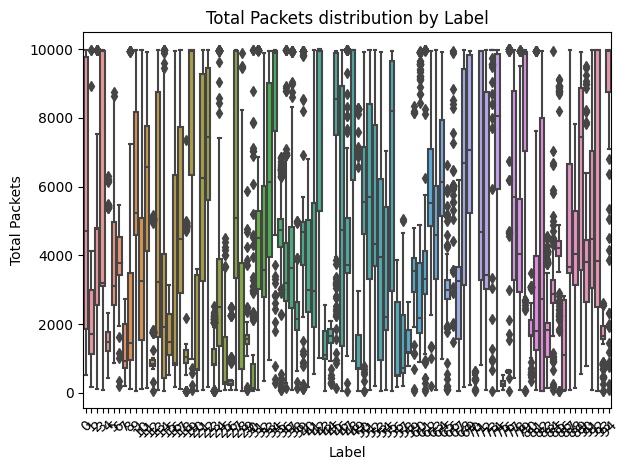

In [ ]:
import seaborn as sns

# 데이터셋에서 피쳐와 레이블 추출 (예시일 뿐, 실제 데이터에 맞게 수정 필요)
features = df_mon[['total packets', '#of incoming packets', '#of outgoing packets', 'ratio of incoming packets', 'ratio of outgoing packets', '#of incoming(first30)', '#of outgoing(first30)', 'total time', '#of packets per sec']]
label = df_mon['label']

# total packets을 label에 따라 시각화
sns.boxplot(x=label, y=features['total packets'])
plt.xlabel('Label')
plt.ylabel('Total Packets')
plt.title('Total Packets distribution by Label')

# x축의 눈금 조정
plt.xticks(rotation=45)  # 눈금을 45도 회전하여 표시
plt.tight_layout()  # 그래프 요소들이 잘리지 않도록 조정
plt.show()


* 산점도 그래프에 의하면, 데이터 셋의 선형적인 규칙이 보이지 않아,
SVM의 kernel 중 선형 kernel인 'linear', 'poly'를 제외한 **'rbf', 'sigmoid' 비선형 kernel을 선택하여 분석을 진**행하였습니다.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

kernels = ['RBF', 'Sigmoid'] # 비 선형 kernel rbf, sigmoid  선택
#A function which returns the corresponding SVC model

def getClassifier(ktype):
    if ktype == 0:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto")
    elif ktype == 1:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto")

In [ ]:
for i in range(2):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    svclassifier = getClassifier(i)
    svclassifier.fit(X_train, y_train)# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: RBF kernel
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       1.00      0.02      0.05        42
           2       1.00      0.07      0.14        41
           3       0.50      0.05      0.09        40
           4       0.50      0.07      0.12        30
           5       0.00      0.00      0.00        35
           6       1.00      0.09      0.17        33
           7       1.00      0.02      0.05        43
           8       1.00      0.11      0.20        36
           9       0.00      0.00      0.00        52
          10       1.00      0.02      0.04        44
          11       0.00      0.00      0.00        40
          12       0.75      0.08      0.14        39
          13       0.00      0.00      0.00        41
          14       1.00      0.18      0.31        33
          15       0.00      0.00      0.00        40
          16       1.00      0.11      0.21        35
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        35
           6       0.00      0.00      0.00        33
           7       0.00      0.00      0.00        43
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00        52
          10       0.00      0.00      0.00        44
          11       0.00      0.00      0.00        40
          12       0.00      0.00      0.00        39
          13       0.00      0.00      0.00        41
          14       0.00      0.00      0.00        33
          15       0.00      0.00      0.00        40
          16       0.00      0.00      0.00        35


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* rbf, sigmoid 커널의 정확도를 비교해본 결과, rbf가 조금 더 높은 accuracy를 지니므로 rbf 커널 모델을 최종으로 선택하기로 하였습니다.

---

## 3-1. Split data into Train/Test

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.svm import LinearSVC, SVC

rbf_model = SVC(kernel='rbf', random_state=0, C=1, gamma=0.0001, probability=True)
# sig_model = SVC(kernel='sigmoid', random_state=0, C=100, gamma=0.0001)
rbf_model.fit(X_train, y_train)     # rbf kernel 모델 훈련시키기
# sig_model.fit(X_train, y_train)     # sigmoid kernel 모델 훈련시키기

SVC(C=1, gamma=0.0001, probability=True, random_state=0)

In [ ]:
rbf_y_pred = rbf_model.predict(X_test)   # rbf kernel 모델 테스트하기
# sig_y_pred = sig_model.predict(X_test)   # sigmoid kernel 모델 테스트하기

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score    ## 정밀도
                                              # -- 올바르게 예측된 데이터의 수를 전체 데이터의 수로 나눈 값
print("rbf accuracy on test dataset : {}".format(accuracy_score(y_test, rbf_y_pred)))
target_names = ['label 0', 'label 1', 'label 2', 'label 3', 'label 4', 'label 5', 'label 6', 'label 7', 'label 8', 'label 9', 'label 10', 'label 11', 'label 12', 'label 13', 'label 14', 'label 15', 'label 16', 'label 17', 'label 18', 'label 19', 'label 20', 'label 21', 'label 22', 'label 23', 'label 24', 'label 25', 'label 26', 'label 27', 'label 28', 'label 29', 'label 30', 'label 31', 'label 32', 'label 33', 'label 34', 'label 35', 'label 36', 'label 37', 'label 38', 'label 39', 'label 40', 'label 41', 'label 42', 'label 43', 'label 44', 'label 45', 'label 46', 'label 47', 'label 48', 'label 49', 'label 50', 'label 51', 'label 52', 'label 53', 'label 54', 'label 55', 'label 56', 'label 57', 'label 58', 'label 59', 'label 60', 'label 61', 'label 62', 'label 63', 'label 64', 'label 65', 'label 66', 'label 67', 'label 68', 'label 69', 'label 70', 'label 71', 'label 72', 'label 73', 'label 74', 'label 75', 'label 76', 'label 77', 'label 78', 'label 79', 'label 80', 'label 81', 'label 82', 'label 83', 'label 84', 'label 85', 'label 86', 'label 87', 'label 88', 'label 89', 'label 90', 'label 91', 'label 92', 'label 93', 'label 94']
print(classification_report(y_test, rbf_y_pred, target_names=target_names))
# precision : 모델 상에서 class X라고 분류된 데이터의 실제 데이터도 class X인 비율
# recall : 모델 상에서 실제 class X인 데이터가 class X로 분류된 비율

rbf accuracy on test dataset : 0.49315789473684213
              precision    recall  f1-score   support

     label 0       0.40      0.32      0.35        38
     label 1       0.32      0.14      0.20        42
     label 2       0.59      0.63      0.61        41
     label 3       0.55      0.45      0.49        40
     label 4       0.54      0.63      0.58        30
     label 5       0.54      0.57      0.56        35
     label 6       0.62      0.79      0.69        33
     label 7       0.46      0.26      0.33        43
     label 8       0.62      0.56      0.59        36
     label 9       0.61      0.52      0.56        52
    label 10       0.54      0.34      0.42        44
    label 11       0.49      0.47      0.48        40
    label 12       0.70      0.90      0.79        39
    label 13       0.43      0.32      0.37        41
    label 14       0.53      0.52      0.52        33
    label 15       0.51      0.53      0.52        40
    label 16       1.00      0

### 5-cross validation(5차 교차 검증)

In [ ]:
## 5-fold-cross-validation 진행(5차 교차검증)
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rbf_model, X_test, y_test, cv= 5)

In [ ]:
print('cross-val-score: {}'.format(scores)) # Report accuracies from each fold
print('cross-val-score.mean: {}'.format(scores.mean())) # the mean accuracy after taking the mean on five accuracies.

cross-val-score: [0.4        0.40263158 0.35921053 0.39473684 0.41447368]
cross-val-score.mean: 0.39421052631578946


## Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 베이스라인 모델 생성 및 학습
  ## RBF kernel을 이용하는 것이 sigmoid kernel을 이용하는 것보다 더 정확도가 높다는 가정이 맞는지 확인해보겠습니다.
  ## 동일 조건 하의 가정을 위하여, C와 gamma값 등의 하이퍼파라미터를 동일하게 조정해봅니다.
sig_model = SVC(kernel='sigmoid', random_state=0, C=1, gamma=0.0001, probability=True)
sig_model.fit(X_train, y_train)

# rbf 모델 평가 지표 계산
rbf_accuracy = accuracy_score(y_test, rbf_y_pred)
rbf_precision = precision_score(y_test, rbf_y_pred, average='weighted')
rbf_recall = recall_score(y_test, rbf_y_pred, average='weighted')
# 다중 클래스에서는 decision_function()으로 결정 함수 값 얻음
rbf_probs = rbf_model.decision_function(X_test)


# 베이스라인 모델(sigmoid 모델) 평가 지표 계산
sig_y_pred = sig_model.predict(X_test)
sig_accuracy = accuracy_score(y_test, sig_y_pred)
sig_precision = precision_score(y_test, sig_y_pred, average='weighted')
sig_recall = recall_score(y_test, sig_y_pred, average='weighted')
# 다중 클래스에서는 decision_function()으로 결정 함수 값 얻음
sig_probs = rbf_model.decision_function(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# SVM with RBF Kernel
rbf_accuracy = accuracy_score(y_test, rbf_y_pred)
rbf_f1 = f1_score(y_test, rbf_y_pred, average='weighted')

print("SVM Model with RBF Kernel:")
print(f"Accuracy: {rbf_accuracy}")
print(f"F1 Score: {rbf_f1}")

# SVM with Sigmoid Kernel
sig_accuracy = accuracy_score(y_test, sig_y_pred)
sig_f1 = f1_score(y_test, sig_y_pred, average='weighted')

print("\nSVM Model with Sigmoid Kernel:")
print(f"Accuracy: {sig_accuracy}")
print(f"F1 Score: {sig_f1}")


SVM Model with RBF Kernel:
Accuracy: 0.49315789473684213
F1 Score: 0.4843730200980484

SVM Model with Sigmoid Kernel:
Accuracy: 0.007368421052631579
F1 Score: 0.0001077929934554254


## using graph plot

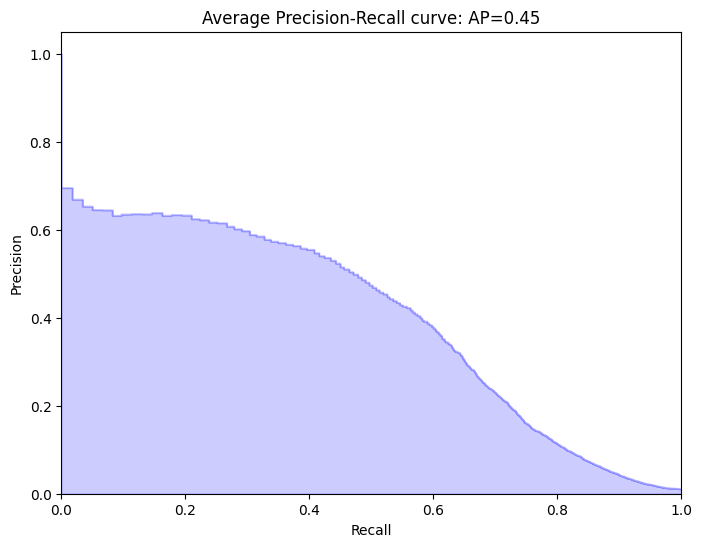

In [ ]:
from sklearn.preprocessing import label_binarize

# 클래스를 이진화하여 One-vs-Rest 전략으로 계산
y_test_bin = label_binarize(y_test, classes=range(95))

# Precision-Recall curve 계산
precision = dict()
recall = dict()
average_precision = dict()

for i in range(95):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], rbf_probs[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], rbf_probs[:, i])

# Micro 평균을 제외한 평균 계산
precision_avg = np.mean(list(precision.values()), axis=0)
recall_avg = np.mean(list(recall.values()), axis=0)
average_precision_avg = np.mean(list(average_precision.values()))

# 평균 Precision-Recall curve 그리기
plt.figure(figsize=(8, 6))
plt.step(recall_avg, precision_avg, color='b', alpha=0.2, where='post')
plt.fill_between(recall_avg, precision_avg, alpha=0.2, color='b', step='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Average Precision-Recall curve: AP={average_precision_avg:.2f}')
plt.show()